In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

class SimpleCIFAR10Model(nn.Module):
    def __init__(self):
        super(SimpleCIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjusted the size here
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Load CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the data into train and validation sets
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=128, shuffle=False, num_workers=4)

# Instantiate the model and move it to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCIFAR10Model().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure that inputs and labels have the same batch size
        if inputs.size(0) != labels.size(0):
            continue

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure that inputs and labels have the same batch size
            if inputs.size(0) != labels.size(0):
                continue

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}, '
          f'Validation Accuracy: {100 * correct / total:.2f}%')


# Save the trained model
torch.save(model.state_dict(), 'simple_cifar10_model.pth')

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Training Loss: 1.6189, Validation Loss: 1.4415, Validation Accuracy: 49.69%
Epoch 2/10, Training Loss: 1.2687, Validation Loss: 1.2199, Validation Accuracy: 56.69%
Epoch 3/10, Training Loss: 1.1132, Validation Loss: 1.1136, Validation Accuracy: 60.49%
Epoch 4/10, Training Loss: 1.0035, Validation Loss: 0.9877, Validation Accuracy: 65.48%
Epoch 5/10, Training Loss: 0.9212, Validation Loss: 0.9850, Validation Accuracy: 65.58%
Epoch 6/10, Training Loss: 0.8515, Validation Loss: 0.9604, Validation Accuracy: 66.02%
Epoch 7/10, Training Loss: 0.7924, Validation Loss: 0.9164, Validation Accuracy: 68.07%
Epoch 8/10, Training Loss: 0.7382, Validation Loss: 0.9136, Validation Accuracy: 68.38%
Epoch 9/10, Training Loss: 0.6882, Validation Loss: 0.8817, Validation Accuracy: 69.35%
Epoch 10/10, Training Loss: 0.6393, Validation Loss: 0.9241, Validation Accuracy: 68.71%
Test Accuracy: 69.19%


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Save the trained model
torch.save(model.state_dict(), 'cifar10_model.pth')

# Test the model
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluate the performance
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')


Test Accuracy: 69.19%
Precision: 69.35%
Recall: 69.19%
F1 Score: 68.58%


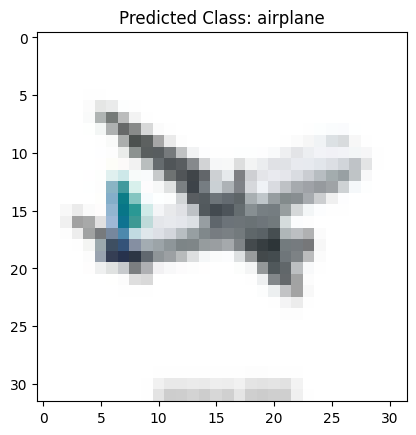

: 

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model = SimpleCIFAR10Model()
model.load_state_dict(torch.load('cifar10_model.pth', map_location='cpu'))
model.eval()

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image_path = 'download (1).jpeg'  # Replace with the path to your image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Make a prediction
with torch.no_grad():
    output = model(input_tensor)

# Map the predicted class index to class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class = torch.argmax(output).item()
predicted_label = class_labels[predicted_class]

# Display the image and prediction
plt.imshow(np.transpose(input_tensor.squeeze().numpy(), (1, 2, 0)))
plt.title(f'Predicted Class: {predicted_label}')
plt.show()
